Un GAN (Generative Adversarial Network) est constitué de deux réseaux neuronaux qui s’affrontent dans un processus d’apprentissage :

Le générateur : il crée des données synthétiques à partir d’un bruit aléatoire. Son objectif est de produire des données qui ressemblent le plus possible aux données réelles.
Le discriminateur : il tente de distinguer les données réelles des données générées par le générateur.
Ces deux réseaux sont en compétition :

Le générateur essaie de tromper le discriminateur en produisant des données de plus en plus réalistes.
Le discriminateur s'améliore progressivement pour mieux différencier les vraies données des fausses.
Ce processus se poursuit jusqu’à ce que le générateur parvienne à créer des données si réalistes que le discriminateur ne puisse plus les distinguer des vraies données.

CTGAN (Conditional Tabular GAN) est un modèle spécialisé dans la génération de données tabulaires synthétiques. Contrairement aux GANs classiques, il prend en compte la nature discrète et continue des variables dans un tableau, ce qui le rend plus efficace pour les bases de données structurées.

In [1]:
pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/21/1b/550ee378512b78847930f5d74228ca1fdba2a7fbdeaac9aeccc085b0e257/lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import precision_score, recall_score, f1_score,\
                            #accuracy_score, balanced_accuracy_score,classification_report,\
                            #plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

np.random.seed(1635848)

In [4]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tensor = tf.constant([1, 2, 3])
numpy_array = tensor.numpy()

In [64]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

class InterestRatePIGAN:
    def __init__(self, latent_dim=32, time_steps=40, rate_columns=None):
        """
        rate_columns: liste des noms des colonnes contenant les taux
        """
        self.latent_dim = latent_dim
        self.time_steps = time_steps
        self.rate_columns = rate_columns
        self.n_rates = len(rate_columns) if rate_columns else 0
        
        if self.n_rates == 0:
            raise ValueError("Vous devez spécifier rate_columns avec les colonnes contenant les taux")
            
        # Initialisation des sigmas
        self.sigmas = tf.Variable(
            tf.random.uniform([self.n_rates], 0.03, 0.1),  # Plage plus large
            trainable=True
        )
                       
        # Optimiseur (version legacy pour éviter le problème)
        self.optimizer = tf.keras.optimizers.legacy.Adam(0.001)
        
        # Construction des modèles
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
        # Compilation du discriminateur
        self.discriminator.compile(loss='binary_crossentropy',
                                 optimizer=self.optimizer,
                                 metrics=['accuracy'])
        
        # Construction du modèle combiné
        self.build_combined_model()
    
    def build_generator(self):
        model = tf.keras.Sequential([
            layers.Dense(128, activation='tanh', input_dim=self.latent_dim + 1),
            layers.Dense(256, activation='tanh'),
            layers.Dense(128, activation='tanh'),
            layers.Dense(self.n_rates)
        ])
        return model
    
    def build_discriminator(self):
        model = tf.keras.Sequential([
            layers.Dense(128, activation='tanh', input_dim=self.n_rates + 1),
            layers.Dense(256, activation='tanh'),
            layers.Dense(128, activation='tanh'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model
    
    def build_combined_model(self):
        """Construction et compilation du modèle combiné"""
        self.discriminator.trainable = False
        
        z = layers.Input(shape=(self.latent_dim,))
        t = layers.Input(shape=(1,))
        inputs = layers.concatenate([z, t])
        
        rates = self.generator(inputs)
        validity = self.discriminator(layers.concatenate([t, rates]))
        
        self.combined = models.Model([z, t], [validity, rates])
        self.combined.compile(loss=['binary_crossentropy', 'mse'],
                            optimizer=self.optimizer)
    
    def physics_loss(self, t, rates):
        # Conversion robuste des inputs
        t_tensor = tf.reshape(tf.convert_to_tensor(t, dtype=tf.float32), [-1, 1])
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t_tensor)
            # Génération des prédictions
            z = tf.random.normal([tf.shape(t_tensor)[0], self.latent_dim])
            rates_pred = self.generator(tf.concat([z, t_tensor], axis=1))
        
        # Calcul des dérivées avec protection
        try:
            dr_dt = tape.gradient(rates_pred, t_tensor)
            if dr_dt is None:
                return tf.constant(0.0)
                
            # Vérification dimensionnelle critique
            tf.debugging.assert_equal(tf.shape(rates_pred), tf.shape(dr_dt))
        except Exception as e:
            print(f"Erreur gradient: {e}")
            return tf.constant(0.0)
        
        # Paramètres dynamiques
        mean_reversion = 0.1
        volatility = 0.05
        
        # Calcul des résidus sécurisé
        residuals = []
        for i in range(tf.minimum(tf.shape(rates_pred)[1], self.n_rates)):
            try:
                # Modèle simplifié mais robuste
                diffusion = self.sigmas[i] * tf.random.normal(tf.shape(rates_pred[:, :1]), stddev=volatility)
                residual = dr_dt[:, i] - (mean_reversion * rates_pred[:, i]) - diffusion
                residuals.append(tf.reduce_mean(tf.square(residual)))
            except:
                continue
        
        return tf.reduce_mean(residuals) if residuals else tf.constant(0.0)
    
    def train(self, data, epochs, batch_size=32):
        # Préparation des données
        scenarios = data.groupby('Scenario')
        all_rates = []
        all_times = []
        
        for _, scenario in scenarios:
            times = scenario['Time_Step'].values
            rates = scenario[self.rate_columns].values
            all_rates.append(rates)
            all_times.append(times)
        
        all_rates = np.array(all_rates)
        all_times = np.array(all_times)

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # Sélection aléatoire
            scenario_idx = np.random.randint(0, len(all_times), batch_size)
            time_idx = np.random.randint(0, self.time_steps, batch_size)
            
            real_t = all_times[scenario_idx, time_idx].reshape(-1, 1)
            real_rates = all_rates[scenario_idx, time_idx]
            
            # Bruit latent
            z = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            # Entraînement du discriminateur
            d_loss_real = self.discriminator.train_on_batch(
                np.column_stack((real_t, real_rates)), valid)
            gen_rates = self.generator.predict(np.column_stack((z, real_t)), verbose=0)
            d_loss_fake = self.discriminator.train_on_batch(
                np.column_stack((real_t, gen_rates)), fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # Entraînement du générateur
            g_loss = self.combined.train_on_batch(
                [z, real_t], [valid, real_rates])
            
            # Perte physique
            p_loss = self.physics_loss(real_t, gen_rates)
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch} | D loss: {d_loss[0]:.4f} | G loss: {g_loss[0]:.4f} | Phys loss: {p_loss:.4f} | Sigmas: {self.sigmas.numpy()}")

    def generate_scenarios(self, n_scenarios=10):
        """Génération de scénarios sans normalisation"""
        scenarios = np.zeros((n_scenarios, self.time_steps, self.n_rates))
        
        for scen_idx in range(n_scenarios):
            for t in range(self.time_steps):
                z = np.random.normal(0, 1, (1, self.latent_dim))
                t_input = np.array([[t]])
                rates = self.generator.predict(np.column_stack((z, t_input)), verbose=0)
                scenarios[scen_idx, t] = rates
        
        return scenarios

In [31]:
data=pd.read_csv("EUR_4Q24_EUR.csv",sep=";", encoding="utf-8")
data = data.replace(',', '.', regex=True).astype(float)

In [32]:
data.columns = data.columns.str.replace(' ', '_')

print(data)

     Scenario  Time_Step  EUR_Nom_Spot_1  EUR_Nom_Spot_2  EUR_Nom_Spot_3  \
0         1.0        0.0        0.023360        0.021924        0.021930   
1         1.0        1.0        0.004213        0.004662        0.005203   
2         1.0        2.0        0.003470        0.004038        0.004465   
3         1.0        3.0        0.005811        0.006172        0.006726   
4         1.0        4.0        0.006319        0.007029        0.007629   
..        ...        ...             ...             ...             ...   
405      10.0       36.0        0.014703        0.014170        0.013539   
406      10.0       37.0        0.007944        0.007294        0.006586   
407      10.0       38.0       -0.000385       -0.001076       -0.001832   
408      10.0       39.0       -0.004658       -0.005440       -0.006024   
409      10.0       40.0       -0.003143       -0.003553       -0.003910   

     EUR_Nom_Spot_4  EUR_Nom_Spot_5  EUR_Nom_Spot_6  EUR_Nom_Spot_7  \
0          0.022

In [ ]:
# Détection des colonnes de taux
rate_columns = [col for col in data.columns if 'EUR_Nom_Spot_' in col]

# Initialisation et entraînement
pigan = InterestRatePIGAN(latent_dim=32, 
                         time_steps=41, 
                         rate_columns=rate_columns)

pigan.train(data, epochs=500, batch_size=50)

# Génération de scénarios
new_scenarios = pigan.generate_scenarios(n_scenarios=10)
print(new_scenarios.shape)  # Devrait afficher (10, 41, n_rates)

/Users/mathieu/anaconda3/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Erreur gradient: Condition x == y did not hold.
Indices of first 1 different values:
[[1]]
Corresponding x values:
[40]
Corresponding y values:
[1]
First 2 elements of x:
[50 40]
First 2 elements of y:
[50  1]
Epoch 0 | D loss: 1.4320 | G loss: 0.5968 | Phys loss: 0.0000 | Sigmas: [0.05628354 0.03626069 0.06656866 0.09798427 0.09359829 0.0696661
 0.03607855 0.09213622 0.05350081 0.07798391 0.08237978 0.05230407
 0.09917599 0.09045415 0.05516507 0.03389613 0.07188965 0.07577597
 0.07311542 0.07906278 0.06038311 0.06221165 0.08804802 0.0972414
 0.08703192 0.09413166 0.05686696 0.03250853 0.08400465 0.07440925
 0.04164405 0.07926947 0.0516298  0.0480817  0.09363563 0.05213204
 0.09071759 0.06984483 0.03816596 0.04765633]
Erreur gradient: Condition x == y did not hold.
Indices of first 1 different values:
[[1]]
Corresponding x values:
[40]
Corresponding y values:
[1]
First 2 elements of x:
[50 40]
First 2 elements of y:
[50  1]
Erreur gradient: Condition x == y did not hold.
Indices of fir

In [60]:
print(new_scenarios)

[[[ 3.94833274e-04 -2.02963650e-02 -1.26742482e-01 ... -2.23976001e-02
   -3.41368355e-02 -1.77381188e-03]
  [-2.53788717e-02 -6.52630627e-02 -3.63895930e-02 ...  3.35425953e-03
    1.75531954e-04  4.70618531e-02]
  [-8.31555109e-03 -2.69794762e-02  8.04978143e-03 ...  2.02186182e-02
    1.52491443e-02  8.97824019e-03]
  ...
  [-7.74358492e-03 -2.19393671e-02  2.31439434e-02 ...  1.78403035e-02
    2.25688927e-02  1.43154487e-02]
  [-7.77249318e-03 -2.19638646e-02  2.31991373e-02 ...  1.78298727e-02
    2.27342509e-02  1.44752339e-02]
  [-7.66383391e-03 -2.19645798e-02  2.31893621e-02 ...  1.77576616e-02
    2.26033293e-02  1.44218281e-02]]

 [[-1.81426294e-02 -3.46624553e-02 -2.68152393e-02 ...  1.23856748e-02
   -1.65406242e-03  2.09704861e-02]
  [ 5.98968286e-03 -2.19672620e-02  8.06863420e-04 ...  1.77101865e-02
    1.31181143e-02  1.14664957e-02]
  [-4.58370429e-03 -2.63929069e-02  1.29510714e-02 ...  1.00108767e-02
    1.73212849e-02  1.31498799e-02]
  ...
  [-7.69643765e-03 -2.1

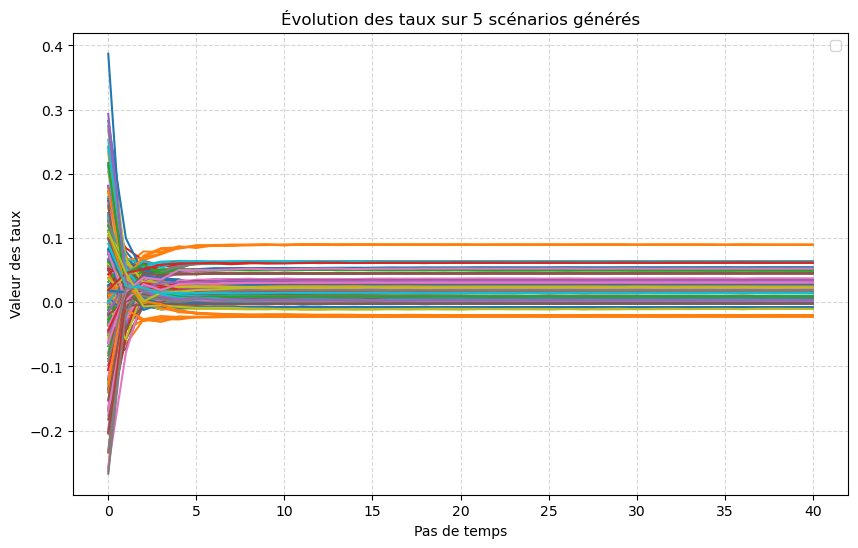

In [61]:
import matplotlib.pyplot as plt

# Tracer les 5 premiers scénarios
plt.figure(figsize=(10, 6))

for i in range(5):  # Prendre seulement les 5 premiers scénarios
    plt.plot(new_scenarios[i])
plt.title('Évolution des taux sur 5 scénarios générés')
plt.xlabel('Pas de temps')
plt.ylabel('Valeur des taux')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()